<a href="https://colab.research.google.com/github/dgokcin/bag-of-features/blob/master/bof-google-colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p><img alt="Colaboratory logo" height="45px" src="/img/colab_favicon.ico" align="left" hspace="10px" vspace="0px"></p>

<h1>What is Colaboratory?</h1>

Colaboratory, or "Colab" for short, allows you to write and execute Python in your browser, with 
- Zero configuration required
- Free access to GPUs
- Easy sharing

Whether you're a **student**, a **data scientist** or an **AI researcher**, Colab can make your work easier. Watch [Introduction to Colab](https://www.youtube.com/watch?v=inN8seMm7UI) to learn more, or just get started below!

## **Getting started**

The document you are reading is not a static web page, but an interactive environment called a **Colab notebook** that lets you write and execute code.

For example, here is a **code cell** with a short Python script that computes a value, stores it in a variable, and prints the result:

In [1]:
seconds_in_a_day = 24 * 60 * 60
seconds_in_a_day

86400

To execute the code in the above cell, select it with a click and then either press the play button to the left of the code, or use the keyboard shortcut "Command/Ctrl+Enter". To edit the code, just click the cell and start editing.

Variables that you define in one cell can later be used in other cells:

In [2]:
seconds_in_a_week = 7 * seconds_in_a_day
seconds_in_a_week

604800

Colab notebooks allow you to combine **executable code** and **rich text** in a single document, along with **images**, **HTML**, **LaTeX** and more. When you create your own Colab notebooks, they are stored in your Google Drive account. You can easily share your Colab notebooks with co-workers or friends, allowing them to comment on your notebooks or even edit them. To learn more, see [Overview of Colab](/notebooks/basic_features_overview.ipynb). To create a new Colab notebook you can use the File menu above, or use the following link: [create a new Colab notebook](http://colab.research.google.com#create=true).

Colab notebooks are Jupyter notebooks that are hosted by Colab. To learn more about the Jupyter project, see [jupyter.org](https://www.jupyter.org).

## Data science

With Colab you can harness the full power of popular Python libraries to analyze and visualize data. The code cell below uses **numpy** to generate some random data, and uses **matplotlib** to visualize it. To edit the code, just click the cell and start editing.

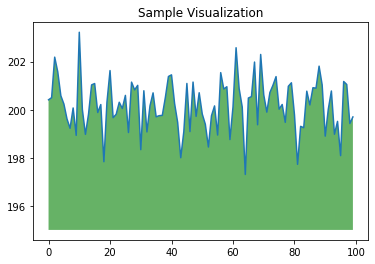

In [3]:
import numpy as np
from matplotlib import pyplot as plt

ys = 200 + np.random.randn(100)
x = [x for x in range(len(ys))]

plt.plot(x, ys, '-')
plt.fill_between(x, ys, 195, where=(ys > 195), facecolor='g', alpha=0.6)

plt.title("Sample Visualization")
plt.show()

You can import your own data into Colab notebooks from your Google Drive account, including from spreadsheets, as well as from Github and many other sources. To learn more about importing data, and how Colab can be used for data science, see the links below under [Working with Data](#working-with-data).

## Machine learning

With Colab you can import an image dataset, train an image classifier on it, and evaluate the model, all in just [a few lines of code](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/quickstart/beginner.ipynb). Colab notebooks execute code on Google's cloud servers, meaning you can leverage the power of Google hardware, including [GPUs and TPUs](#using-accelerated-hardware), regardless of the power of your machine. All you need is a browser.

Colab is used extensively in the machine learning community with applications including:
- Getting started with TensorFlow
- Developing and training neural networks
- Experimenting with TPUs
- Disseminating AI research
- Creating tutorials

To see sample Colab notebooks that demonstrate machine learning applications, see the [machine learning examples](#machine-learning-examples) below.

## More Resources

### Working with Notebooks in Colab
- [Overview of Colaboratory](/notebooks/basic_features_overview.ipynb)
- [Guide to Markdown](/notebooks/markdown_guide.ipynb)
- [Importing libraries and installing dependencies](/notebooks/snippets/importing_libraries.ipynb)
- [Saving and loading notebooks in GitHub](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)
- [Interactive forms](/notebooks/forms.ipynb)
- [Interactive widgets](/notebooks/widgets.ipynb)
- <img src="/img/new.png" height="20px" align="left" hspace="4px" alt="New"></img>
 [TensorFlow 2 in Colab](/notebooks/tensorflow_version.ipynb)

<a name="working-with-data"></a>
### Working with Data
- [Loading data: Drive, Sheets, and Google Cloud Storage](/notebooks/io.ipynb) 
- [Charts: visualizing data](/notebooks/charts.ipynb)
- [Getting started with BigQuery](/notebooks/bigquery.ipynb)

### Machine Learning Crash Course
These are a few of the notebooks from Google's online Machine Learning course. See the [full course website](https://developers.google.com/machine-learning/crash-course/) for more.
- [Intro to Pandas](/notebooks/mlcc/intro_to_pandas.ipynb)
- [Tensorflow concepts](/notebooks/mlcc/tensorflow_programming_concepts.ipynb)
- [First steps with TensorFlow](/notebooks/mlcc/first_steps_with_tensor_flow.ipynb)
- [Intro to neural nets](/notebooks/mlcc/intro_to_neural_nets.ipynb)
- [Intro to sparse data and embeddings](/notebooks/mlcc/intro_to_sparse_data_and_embeddings.ipynb)

<a name="using-accelerated-hardware"></a>
### Using Accelerated Hardware
- [TensorFlow with GPUs](/notebooks/gpu.ipynb)
- [TensorFlow with TPUs](/notebooks/tpu.ipynb)

<a name="machine-learning-examples"></a>

## Machine Learning Examples

To see end-to-end examples of the interactive machine learning analyses that Colaboratory makes possible, check out the [AI Hub](https://aihub.cloud.google.com/) project.

A few featured examples:

- [Neural Style Transfer](https://aihub.cloud.google.com/p/products%2F7f7495dd-6f66-4f8a-8c30-15f211ad6957): Use deep learning to transfer style between images.
- [EZ NSynth](https://aihub.cloud.google.com/p/products%2Fcddd17cf-5f86-4ce7-b6b6-03c5e52ee0fb): Synthesize audio with WaveNet auto-encoders.
- [Fashion MNIST with Keras and TPUs](https://aihub.cloud.google.com/p/products%2F7a0acf15-0be0-41a6-9bdb-5a5abd4e8fbf): Classify fashion-related images with deep learning.
- [DeepDream](https://aihub.cloud.google.com/p/products%2Ff9e8fc11-ad0f-410a-bebe-2482066ce570): Produce DeepDream images from your own photos.
- [Convolutional VAE](https://aihub.cloud.google.com/p/products%2Ff5e8dd20-6b34-44a0-bc45-6e345e36a4e7): Create a generative model of handwritten digits.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
!pip uninstall opencv-python -y
# downgrade OpenCV a bit since some none-free features are not avilable
!pip install opencv-contrib-python==3.4.2.17 --force-reinstall

Uninstalling opencv-python-4.1.2.30:
  Successfully uninstalled opencv-python-4.1.2.30
     |████████████████████████████████| 30.6MB 102kB/s 
     |████████████████████████████████| 20.2MB 102kB/s 
ERROR: imgaug 0.2.9 requires opencv-python, which is not installed.
ERROR: dopamine-rl 1.0.5 requires opencv-python>=3.4.1.15, which is not installed.
ERROR: albumentations 0.1.12 requires opencv-python, which is not installed.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.18.4
    Uninstalling numpy-1.18.4:
      Successfully uninstalled numpy-1.18.4
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [0]:
#@title Default title text
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn import preprocessing

import cv2
import numpy as np
import os
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt


In [0]:
def getFiles(train, path):
    images = []
    count = 0
    for folder in os.listdir(path):
        for file in os.listdir(os.path.join(path, folder)):
            images.append(os.path.join(path, os.path.join(folder, file)))

    # if (train is True):
    #     np.random.shuffle(images)

    return images

In [0]:
def draw_keypoints(img, kp):
    keypoints = cv2.drawKeypoints(img, kp, outImage=None)
    plt.figure(figsize=(20, 10))
    plt.imshow(keypoints)
    plt.show()

In [0]:
def getDescriptors(sift, img, feature_extraction):
    if feature_extraction == 'kp':
        kp, des = sift.detectAndCompute(img, None)
        # draw_keypoints(img, kp)
        return des
    if feature_extraction == 'grid':
        step_size = 15
        kp = [cv2.KeyPoint(x, y, step_size) for y in
              range(0, img.shape[0], step_size)
              for x in range(0, img.shape[1], step_size)]

        kp, des = sift.compute(img, kp)
        # draw_keypoints(img, kp)

        return des


In [0]:
def readImage(img_path):
    img = cv2.imread(img_path, 0)
    # return cv2.resize(img, (150, 150))
    return img

In [0]:
def vstackDescriptors(descriptor_list):
    descriptors = np.array(descriptor_list[0])
    for descriptor in descriptor_list[1:]:
        descriptors = np.vstack((descriptors, descriptor))

    return descriptors


In [0]:
def clusterDescriptors(descriptors, no_clusters, alg):
    scaler = preprocessing.StandardScaler()
    descriptors_normalized = scaler.fit_transform(descriptors)

    if alg == 'kmeans':
        kmeans = KMeans(n_clusters=no_clusters).fit(descriptors_normalized)
        return kmeans
    elif alg == 'meanshift':

        bandwidth = estimate_bandwidth(descriptors_normalized, quantile=.002,
                                       n_samples=30000)

        ms = MeanShift(bandwidth=bandwidth, n_jobs=-1, bin_seeding=True,
                       cluster_all=False)
        # ms = MeanShift(bandwidth=bandwidth, n_jobs=-1, bin_seeding=True)
        ms.fit(descriptors_normalized)
        labels = ms.labels_
        cluster_centers = ms.cluster_centers_
        print(bandwidth)
        # print(cluster_centers)

        labels_unique = np.unique(labels)
        n_clusters_ = len(labels_unique)

        print("number of estimated clusters : %d" % n_clusters_)

        return ms


In [0]:
def extractFeatures(cluster, descriptor_list, image_count, no_clusters):
    histogram = np.array([np.zeros(len(cluster.cluster_centers_)) for i in
                            range(image_count)])
    for i in range(image_count):
        for j in range(len(descriptor_list[i])):
            feature = descriptor_list[i][j]
            feature = feature.reshape(1, 128)
            # nearest neigh.
            idx = cluster.predict(feature)
            histogram[i][idx] += 1

    return histogram


In [0]:
def normalizeFeatures(scale, features):
    return scale.transform(features)

In [0]:
def plotHistogram(im_features, no_clusters):
    x_scalar = np.arange(no_clusters)
    y_scalar = np.array(
        [abs(np.sum(im_features[:, h], dtype=np.int32)) for h in
         range(no_clusters)])

    plt.bar(x_scalar, y_scalar)
    plt.xlabel("Visual Word Index")
    plt.ylabel("Frequency")
    plt.title("Complete Vocabulary Generated")
    # plt.xticks(x_scalar + 0.4, x_scalar)
    plt.show()

In [0]:
def plotConfusionMatrix(y_true, y_pred, classes,
                        normalize=False,
                        title=None,
                        cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


In [0]:
def plotConfusions(true, predictions):
    np.set_printoptions(precision=2)

    class_names = ["airplanes", "cars", "faces", "motorbikes"]
    plotConfusionMatrix(true, predictions, classes=class_names,
                        title='Confusion matrix, without normalization')

    plotConfusionMatrix(true, predictions, classes=class_names, normalize=True,
                        title='Normalized confusion matrix')

    plt.show()


In [0]:
def findAccuracy(true, predictions):
    print('accuracy score: %0.3f' % accuracy_score(true, predictions))


In [0]:
def trainModel(path, no_clusters, clustering_alg, feature_extraction):
    images = getFiles(True, path)
    print("Train images path detected.")
    sift = cv2.xfeatures2d.SIFT_create()
    descriptor_list = []
    train_labels = np.array([])
    image_count = len(images)

    for img_path in images:
        if ("airplanes" in img_path):
            class_index = 0
        elif ("cars" in img_path):
            class_index = 1
        elif ("faces" in img_path):
            class_index = 2
        elif ("motorbikes" in img_path):
            class_index = 3

        train_labels = np.append(train_labels, class_index)
        img = readImage(img_path)
        # Feature Extraction
        des = getDescriptors(sift, img, feature_extraction)
        descriptor_list.append(des)

    descriptors = vstackDescriptors(descriptor_list)
    print("Descriptors vstacked.")

    # Dict Computation
    cluster = clusterDescriptors(descriptors, no_clusters, alg=clustering_alg)
    print("Descriptors clustered with " + clustering_alg)

    im_features = extractFeatures(cluster, descriptor_list, image_count,
                                  no_clusters)
    print("Images features extracted.")

    scale = StandardScaler().fit(im_features)
    im_features = scale.transform(im_features)
    print("Train images normalized.")

    if clustering_alg == 'meanshift':
        pass
        # labels = cluster.labels_
        # cluster_centers = cluster.cluster_centers_
        #
        # labels_unique = np.unique(labels)
        # n_clusters_ = len(labels_unique)
        # plotHistogram(im_features, n_clusters_)
    else:
        plotHistogram(im_features, no_clusters)

    print("Features histogram plotted.")
    clf = LinearSVC()
    clf.fit(im_features, np.array(train_labels))

    print("SVM fitted.")
    print("Training completed.")

    return cluster, scale, clf, im_features


In [0]:
def testModel(path, cluster, scale, svm, im_features, no_clusters,
              feature_extraction):
    test_images = getFiles(False, path)
    print("Test images path detected.")

    count = 0
    true = []
    descriptor_list = []

    name_dict = {
        "0": "airplanes",
        "1": "cars",
        "2": "faces",
        "3": "motorbikes",
    }

    sift = cv2.xfeatures2d.SIFT_create()

    for img_path in test_images:
        img = readImage(img_path)
        des = getDescriptors(sift, img, feature_extraction)

        if (des is not None):
            count += 1
            descriptor_list.append(des)

            if ("airplanes" in img_path):
                true.append("airplanes")
            elif ("cars" in img_path):
                true.append("cars")
            elif ("faces" in img_path):
                true.append("faces")
            elif ("motorbikes" in img_path):
                true.append("motorbikes")

    descriptors = vstackDescriptors(descriptor_list)

    test_features = extractFeatures(cluster, descriptor_list, count,
                                    no_clusters)

    test_features = scale.transform(test_features)

    kernel_test = test_features

    predictions = [name_dict[str(int(i))] for i in svm.predict(kernel_test)]
    print("Test images classified.")

    plotConfusions(true, predictions)
    print("Confusion matrixes plotted.")

    findAccuracy(true, predictions)
    print("Accuracy calculated.")
    print("Execution done.")


In [0]:
def execute(train_path, test_path, no_clusters, clustering_alg,
            feature_extraction):
    cluster, scale, svm, im_features = trainModel(train_path, no_clusters,
                                                 clustering_alg, feature_extraction)


    # Save the SVM
    # joblib.dump((cluster, scale, svm, im_features), (save_file + ".pkl"),
    #             compress=3)
    #
    # cluster, scale, svm, im_features = joblib.load(save_file + ".pkl")

    testModel(test_path, cluster, scale, svm, im_features, no_clusters, feature_extraction)


In [0]:
    execute('/content/drive/My Drive/bag-of-features/dataset-modified/train', '/content/drive/My Drive/bag-of-features/dataset-modified/test', 50,'kmeans', 'grid')

Train images path detected.
Descriptors vstacked.
